# Here are the library you need to import

In [21]:
import PIL
import time
import torch
import torchvision
import torch.nn.functional as F
from einops import rearrange
from torch import nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import glob
import scipy.io
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
from random import randint
import random
import time
import re
from timm.models.layers import DropPath
from einops import rearrange
from scipy import ndimage
from skimage import io
from skimage import transform
from natsort import natsorted
from skimage.transform import rotate, AffineTransform
from timm.models.layers import DropPath, to_3tuple, trunc_normal_
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    RandAffined,
    RandCropByLabelClassesd,
    SpatialPadd,
    RandAdjustContrastd,
    RandShiftIntensityd,
    ScaleIntensityd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    ScaleIntensityRangePercentilesd,
    Resized,
    Transposed,
    ResizeWithPadOrCropd
)
from monai.transforms import (CastToTyped,
                              Compose, CropForegroundd, EnsureChannelFirstd, LoadImaged,
                              NormalizeIntensity, RandCropByPosNegLabeld,
                              RandFlipd, RandGaussianNoised,
                              RandGaussianSmoothd, RandScaleIntensityd,
                              RandZoomd, SpatialCrop, SpatialPadd, EnsureTyped)

#The diffusion module adpated from https://github.com/openai/guided-diffusion
from diffusion.Create_diffusion import *
from diffusion.resampler import *
from diffusion.normal_diffusion import GaussianDiffusionSampler, GaussianDiffusionTrainer
import matplotlib.pyplot as plt

# Build the data loader using the monai library

In [22]:
# Here are the dataloader hyper-parameters, including the batch size,
# image size, image spacing, and color channel (usually 1 for medical images)
BATCH_SIZE_TRAIN = 8*1
image_size = 256
img_size = (image_size,image_size)
spacing = (1,1)
channels = 1

In [23]:
# Here we use monai to process the nii data. If you use other format, check monai so it can read the data.
# load image using PILreader (read nii) -> add channel dimension to the image -> ensure orientation -> respacing all image to
# a same spacing -> intensity normalization -> padding or crop the boundary to ensure all images have same size

class CustomDataset(Dataset):
    def __init__(self,imgs_path):
        self.imgs_path = imgs_path
        file_list = natsorted(glob.glob(self.imgs_path + "*"), key=lambda y: y.lower())
        self.data = []
        for img_path in file_list:
            class_name = img_path.split("/")[-1]
            self.data.append([img_path, class_name])
        self.train_transforms = Compose(
                [
                    LoadImaged(keys=["image"],reader='PILreader'),
                    AddChanneld(keys=["image"]),
                    #Orientationd(keys=["image"], axcodes="RAS"),
                    Spacingd(
                        keys=["image"],
                        pixdim=spacing,
                        mode=("bilinear"),
                    ),
                    ScaleIntensityd(keys=["image"], minv=-1, maxv=1.0),
                    ResizeWithPadOrCropd(
                        keys=["image"],
                        spatial_size=(256,256),
                        constant_values = -1,
                    ),
                    ToTensord(keys=["image"]),
                ]
            )
  
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx,):

        img_path, class_name = self.data[idx]
        cao = {"image":img_path}
        affined_data_dict = self.train_transforms(cao)                    
        img_tensor =affined_data_dict['image'].to(torch.float)
        
        return img_tensor

# Build the TDM process

In [24]:
# These three parameters: training steps number, learning variance or not (using improved DDPM or original DDPM), and inference 
# timesteps number (only effective when using improved DDPM)
diffusion_steps=1000
learn_sigma=True
timestep_respacing=[50]

# Don't toch these parameters, they are irrelant to the image synthesis
sigma_small=False
class_cond=False
noise_schedule='linear'
use_kl=False
predict_xstart=False
rescale_timesteps=True
rescale_learned_sigmas=True
use_checkpoint=False


diffusion = create_gaussian_diffusion(
    steps=diffusion_steps,
    learn_sigma=learn_sigma,
    sigma_small=sigma_small,
    noise_schedule=noise_schedule,
    use_kl=use_kl,
    predict_xstart=predict_xstart,
    rescale_timesteps=rescale_timesteps,
    rescale_learned_sigmas=rescale_learned_sigmas,
    timestep_respacing=timestep_respacing,
)
schedule_sampler = UniformSampler(diffusion)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Build the TDM network

In [25]:
# Here enter your network parameters:num_channels means the initial channels in each block,
# channel_mult means the multipliers of the channels (in this case, 128,128,256,256,512,512 for the first to the sixth block),
# attention_resulution means we use the transformer blocks in the third to the sixth block
# number of heads, window size in each transformer block
# 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_channels=128
channel_mult = (1, 1, 2, 2, 4, 4)
attention_resolutions="64,32,16,8"
num_heads=[4,4,4,8,16,16]
window_size = [[4,4],[4,4],[4,4],[8,8],[8,8],[4,4]]
num_res_blocks = [2,2,1,1,1,1]
sample_kernel=([2,2],[2,2],[2,2],[2,2],[2,2]),

attention_ds = []
for res in attention_resolutions.split(","):
    attention_ds.append(int(res))
class_cond = False
use_scale_shift_norm=True
resblock_updown = False

from network.Diffusion_model_transformer import *
model = SwinVITModel(
        image_size=(image_size,image_size),
        in_channels=1,
        model_channels=num_channels,
        out_channels=2,
        sample_kernel=sample_kernel,
        num_res_blocks=num_res_blocks,
        attention_resolutions=tuple(attention_ds),
        dropout=0,
        channel_mult=channel_mult,
        num_classes=(NUM_CLASSES if class_cond else None),
        use_checkpoint=False,
        use_fp16=False,
        num_heads=num_heads,
        window_size = window_size,
        num_head_channels=64,
        num_heads_upsample=-1,
        use_scale_shift_norm=use_scale_shift_norm,
        resblock_updown=resblock_updown,
        use_new_attention_order=False,
    ).to(device)


cuda:0


In [26]:
# #In case you want to use CNN
# from network.Diffusion_model_Unet import *
# model = UNetModel(
#         image_size=image_size,
#         in_channels=1,
#         model_channels=num_channels,
#         out_channels=2,
#         num_res_blocks=num_res_blocks[0],
#         attention_resolutions=tuple(attention_ds),
#         dropout=0.,
#         sample_kernel=sample_kernel,
#         channel_mult=channel_mult,
#         num_classes=(NUM_CLASSES if class_cond else None),
#         use_checkpoint=False,
#         use_fp16=False,
#         num_heads=4,
#         num_head_channels=64,
#         num_heads_upsample=-1,
#         use_scale_shift_norm=use_scale_shift_norm,
#         resblock_updown=False,
#         use_new_attention_order=False,
#     ).to(device)

# Call the optimizer and ready for start

In [27]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('parameter number is '+str(pytorch_total_params))
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5,weight_decay = 1e-4)

parameter number is 116042570


# Build the training function. Run the training function once = one epoch

In [28]:
# Here we explain the training process
def train(model, optimizer,data_loader1, loss_history):
    
    #1: set the model to training mode
    model.train()
    total_samples = len(data_loader1.dataset)
    loss_sum = []
    total_time = 0
    
    #2: Loop the whole dataset, x1 (traindata) is the image batch
    for i, x1 in enumerate(data_loader1):

        traindata = x1.to(device)
        
        #3: extract random timestep for training
        t, weights = schedule_sampler.sample(traindata.shape[0], device)

        aa = time.time()
        
        #4: Optimize the TDM network
        optimizer.zero_grad()
        all_loss = diffusion.training_losses(model,traindata,t=t)
        loss = (all_loss["loss"] * weights).mean()
        loss.backward()
        loss_sum.append(loss.detach().cpu().numpy())
        optimizer.step()
        
        #5:print out the intermediate loss for every 100 batches
        total_time += time.time()-aa
        if i % 100 == 0:
            print('optimization time: '+ str(time.time()-aa))
            print('[' +  '{:5}'.format(i * BATCH_SIZE_TRAIN) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader1)) + '%)]  Loss: ' +
                  '{:6.7f}'.format(np.nanmean(loss_sum)))

    #6: print out the average loss for this epoch
    average_loss = np.nanmean(loss_sum) 
    loss_history.append(average_loss)
    print("Total time per sample is: "+str(total_time))
    print('Averaged loss is: '+ str(average_loss))
    return average_loss

# Build the testing function.

In [33]:
# Run the evaluate function will generate 4 samples and will be save to a folder in MAT format
num_sample = 4
def evaluate(model,epoch,path):
    model.eval()
    aa = time.time()
    prediction = []
    true = []
    img = []
    loss_all = []
    with torch.no_grad():
        x_clean = diffusion.p_sample_loop(model,(num_sample, 1, image_size, image_size),clip_denoised=True)
        img.append(x_clean.cpu().numpy())
    print('Generate for the epoch #'+str(epoch)+' result:')
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.figure()
    f, axarr = plt.subplots(1,num_sample)
    for ind in range(num_sample):
        axarr[ind].imshow(x_clean[ind,0,:,:].cpu().numpy(), cmap='gray')
    plt.show()
    data = {"img":img}
    print(str(time.time()-aa))
    scipy.io.savemat(path+ 'test_example_epoch'+str(epoch)+'.mat',data)

# Start the training and testing

Epoch: 0
optimization time: 1.0577466487884521
[    0/ 1902 (  0%)]  Loss: 0.0140100
optimization time: 0.7928736209869385
[  800/ 1902 ( 42%)]  Loss: 0.0261331
optimization time: 0.7901201248168945
[ 1600/ 1902 ( 84%)]  Loss: 0.0254084
Total time per sample is: 187.96186232566833
Averaged loss is: 0.026431048
Execution time: 213.92 seconds
Generate for the epoch #0 result:


<Figure size 1440x1440 with 0 Axes>

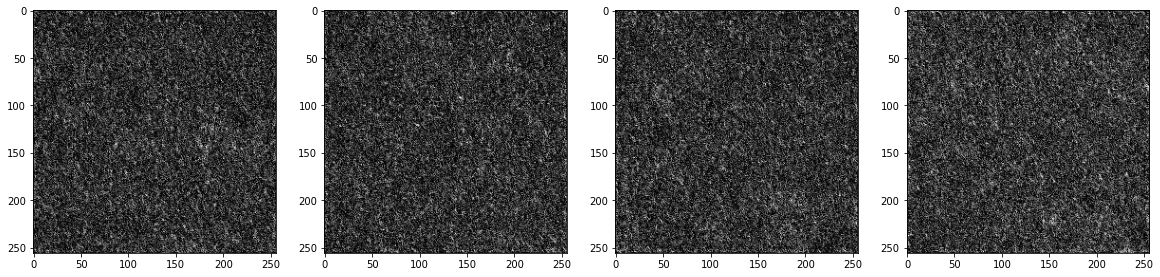

7.4003987312316895
Save the latest best model
Epoch: 1
optimization time: 0.7786238193511963
[    0/ 1902 (  0%)]  Loss: 0.0332491


In [ ]:
# Enter your data folder
training_set1 = CustomDataset('C:\Pan research\Diffusion model\ACDC_2D/train/')
# Enter your data reader parameters
params = {'batch_size': BATCH_SIZE_TRAIN,
          'shuffle': True,
          'pin_memory': True,
          'drop_last': False}
train_loader1 = torch.utils.data.DataLoader(training_set1, **params)

# Enter your total number of epoch
N_EPOCHS = 500

# Enter the address you save the checkpoint and the evaluation examples
path ="C:/Pan research/Diffusion model/result/ACDC/"
PATH = path+'ViTRes1.pt' # Use your own path
best_loss = 1
if not os.path.exists(path):
  os.makedirs(path) 
train_loss_history, test_loss_history = [], []

# Uncomment this when you resume the checkpoint
# model.load_state_dict(torch.load(PATH),strict=False) 
for epoch in range(0, N_EPOCHS):
    print('Epoch:', epoch)
    start_time = time.time() 
    average_loss = train(model, optimizer, train_loader1, train_loss_history)
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    if epoch % 5 == 0:
        evaluate(model,epoch,path)
        print('Save the latest best model')
        torch.save(model.state_dict(), PATH)
print('Execution time')